##### importing libraries

In [1]:
import os
import cv2
from random import shuffle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix

##### extracting data from local dir

In [2]:
data = {
    'imgs' : [],
    'labels' : []
}

datapath = r"C:\Users\US593\OneDrive\Desktop\conveyor_belt_pizza_counter\classifier\data1"
count = 0 

for classes in os.listdir(datapath):
    classes_path = os.path.join(datapath,classes)
    class_name = classes
    for filename in os.listdir(classes_path):
        if filename is not None: 
            data['labels'].append(class_name)
            filepath = os.path.join(classes_path,filename)
            img = cv2.imread(filepath)
            resized_img = cv2.resize(img,(7,4))
            img = cv2.cvtColor(resized_img,cv2.COLOR_BGR2RGB)
            data['imgs'].append(img)
            count += 1
            if count%100 == 0 : 
                print(f"processed {count}")

processed 100
processed 200
processed 300
processed 400


##### shuffling data for better visualization

In [3]:
combined = list(zip(data['imgs'], data['labels']))
shuffle(combined)
data['shuffled_imgs'],data['shuffled_labels'] = zip(*combined)

##### data visualization

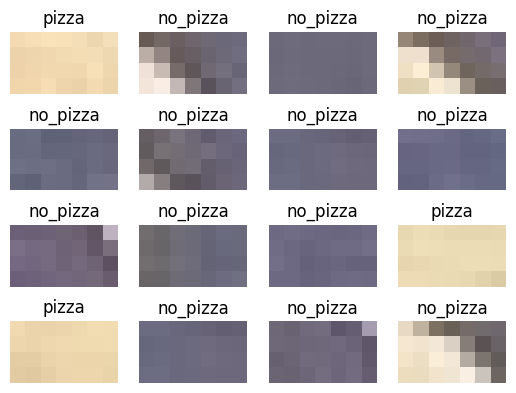

In [4]:
i = 0
for label , img in zip(data['shuffled_labels'][:16],data['shuffled_imgs'][:16]):
    ax = plt.subplot(4,4,i+1) # create subplot with in grid with (rows,columns,index)
    plt.imshow(img)
    plt.title(label)
    plt.axis('off')
    i += 1
    if i == 16:
        break

##### label_encoding

In [5]:
data.keys()

dict_keys(['imgs', 'labels', 'shuffled_imgs', 'shuffled_labels'])

In [6]:
labels = np.array(data['shuffled_labels'])

In [7]:
le = LabelEncoder()
encoded_labels = le.fit_transform(labels)

In [8]:
encoded_labels.shape

(498,)

In [9]:
encoded_labels[:5]

array([1, 0, 0, 0, 0], dtype=int64)

1 ==> pizza

0 ==> no_pizza

##### flattening-out images

In [10]:
images = np.array(data['shuffled_imgs'])

In [11]:
images.shape

(498, 4, 7, 3)

In [12]:
flattened_imgs = np.reshape(images, (498,84))

In [13]:
flattened_imgs.shape

(498, 84)

##### normalization

In [14]:
flattened_imgs[0][:10]

array([243, 218, 178, 247, 222, 182, 249, 226, 185, 248], dtype=uint8)

In [15]:
scaler = MinMaxScaler()

In [16]:
scaled_imgs = scaler.fit_transform(flattened_imgs)

In [17]:
scaled_imgs[0][:10]

array([0.92638037, 0.87179487, 0.72108844, 0.94968553, 0.89032258,
       0.74496644, 0.9689441 , 0.94666667, 0.81818182, 0.95705521])

In [18]:
pickle.dump(scaler, open(f'min_max_scaler.p', 'wb'))

##### trian_test_split

In [19]:
from sklearn.model_selection import train_test_split

In [20]:
x_train,x_test,y_train,y_test = train_test_split(scaled_imgs, encoded_labels, test_size = 0.2, stratify = encoded_labels, shuffle = True, random_state = 33)

In [21]:
x_train.shape

(398, 84)

In [22]:
y_train.shape

(398,)

In [23]:
x_test.shape

(100, 84)

In [24]:
y_test.shape

(100,)

##### training multiple models using GridSearchCV

In [25]:
from sklearn.model_selection import ShuffleSplit, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

def gridsearchcv(X, y):
    algos = {
        'naive_bayes': {
            'model': GaussianNB(),
            'params': {
               'priors' : [None]
            }
        },
        'random_forest': {
            'model': RandomForestClassifier(),
            'params': {
                'criterion' : ['gini']
            }
        }
    }
    scores = []
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
    for algo_name, config in algos.items():
        gscv = GridSearchCV(config['model'], config['params'], cv=cv, return_train_score=False)
        gscv.fit(X, y)
        scores.append({
            'model': algo_name,
            'best_score': gscv.best_score_,
            'best_params': gscv.best_params_
        })
        best_estimator = gscv.best_estimator_
        pickle.dump(best_estimator, open(f'{algo_name}_model.p', 'wb'))
        
    return pd.DataFrame(scores, columns=['model', 'best_score', 'best_params'])


In [26]:
stats = gridsearchcv(x_train,y_train)

##### saving & showing training stats

In [27]:
stats.to_csv('stats.csv')

In [28]:
stats

,model,best_score,best_params
0,naive_bayes,1.0,{'priors': None}
1,random_forest,1.0,{'criterion': 'gini'}


##### Naive Bayes Model Evaluation

In [29]:
with open('naive_bayes_model.p', 'rb') as file:
    model1 = pickle.load(file)

In [30]:
model1.score(x_train,y_train)

1.0

In [31]:
model1.score(x_test,y_test)

1.0

Text(58.222222222222214, 0.5, 'Truth')

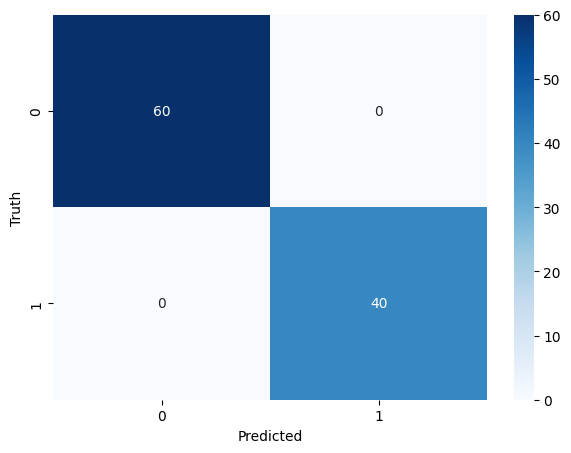

In [32]:
cm = confusion_matrix(y_test, model1.predict(x_test))
plt.figure(figsize = (7,5))
sns.heatmap(cm, annot=True, cmap=plt.cm.Blues)
plt.xlabel('Predicted')
plt.ylabel('Truth')

##### Random Forest Model Evaluation

In [33]:
with open('random_forest_model.p', 'rb') as file:
    model2 = pickle.load(file)

In [34]:
model2.score(x_train,y_train)

1.0

In [35]:
model2.score(x_test,y_test)

1.0

Text(58.222222222222214, 0.5, 'Truth')

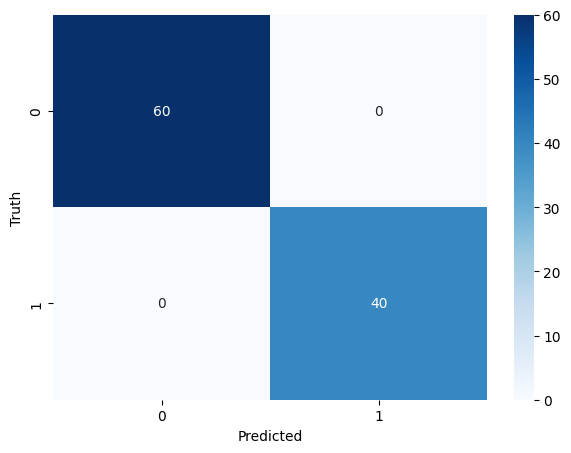

In [36]:
cm = confusion_matrix(y_test, model2.predict(x_test))
plt.figure(figsize = (7,5))
sns.heatmap(cm, annot=True, cmap=plt.cm.Blues)
plt.xlabel('Predicted')
plt.ylabel('Truth')